# Dynamic Flux Balance Analysis (dFBA) 
Dynamic Flux Balance Analysis (dFBA) is a computational modeling technique used to simulate the dynamic behavior of metabolic networks over time. It is an extension of Flux Balance Analysis (FBA), which is a widely used constraint-based method to predict steady-state metabolic flux distributions in biological systems. While FBA is effective at predicting the steady-state behavior of metabolic networks, it is limited in its ability to capture dynamic changes in metabolic activity over time, such as those that occur during aging, adaptation to changing environments, or the impact of genetic modifications. This is where dFBA comes in, by incorporating time-varying parameters and dynamic constraints into the FBA framework. 
###### Time-dependency: 
dFBA accurately models metabolic networks by considering time-varying factors like metabolite concentrations and aging.
###### Dynamic constraints:  
dFBA includes constraints on metabolic fluxes to reflect changing environments or regulatory mechanisms.
###### ODE integration: 
dFBA combines ordinary differential equations with FBA-derived optimization problems for comprehensive metabolic network representation.
###### Flexibility:
dFBA can be tailored to specific systems or conditions using relevant experimental data or constraints.


In this notebook, we demonstrate dFBA using an E. coli SBML model obtained from the BiGG dataset. Users can adjust the number of simulation time-steps. We set constraints for nutrient availability in the environment. User set the initial Glucose concentration.  

In [1]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from vivarium.plots.topology import plot_topology
from bigraph_viz import convert_vivarium_composite, plot_bigraph
from escher import Builder

In [2]:
# Import the ReactionBounds, DynamicFBA classes and the main function from the dFBA.py file
import sys
sys.path.append('../vivarium_microbiome/processes/')
from dFBA import ReactionBounds, DynamicFBA, BiomassCalculator, EnvCalculator, main

In this notebook, we utilize an E. coli SBML file from the BiGG dataset, which provides a standardized format for representing metabolic network models in FBA. The SBML file contains information on metabolites, reactions, stoichiometry, and constraints, allowing researchers to investigate system dynamics using FBA and related methods like dFBA. This notebook can also accommodate SBML files for other organisms. Users can customize the number of simulation time-steps for running the simulations.

E.Coli model reference:

Orth, J. D., Fleming, R. M., & Palsson, B. . (2010). Reconstruction and use of microbial metabolic networks: the core Escherichia coli metabolic model as an educational guide. EcoSal plus, 4(1).

In [3]:
model_path = "../vivarium_microbiome/data/e_coli_core.xml"
simulation_time = 5 # in seconds
init_concentration = 11.1  # initial concentration value
env_parameters = {'km': 0.1}
initial_state = {
    'microbiome': {
        'bacteria': {
            'regulation_probability': 0.3,
            'gene_expression': 0.03
        }
    }
}

In [4]:
# Call the main function with the model_path and simulation_time
data, output, processes, topology = main(
    model_path, 
    simulation_time, 
    env_parameters, 
    init_concentration, 
    initial_state=initial_state)


Simulation ID: 646b854a-1060-11ee-9cf4-ba21c95c07d9
Created: 06/21/2023 at 14:21:08
updated_bounds =  {'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.0), 'D_LACt2': (-1000.0, 1000.0), 'ENO': (-1000.0, 1000.0)

## Model Topology
The diagram provided depicts the topology of our model. In this model, dynamic flux balance analysis (dFBA) is employed, wherein flux balance analysis (FBA) is calculated at each time step while considering the reaction bounds.

To facilitate the DynamicFBA process and compute fluxes, including the objective flux, it is imperative to have reaction bounds and reaction lists derived from the SBML model. Initially, the reaction bounds are obtained from the SBML file, but they evolve over time based on environmental factors (specifically, the glucose concentration in this model) and enzyme concentration.

Enzyme concentration is determined through a cascade of functions, whereby regulatory proteins control gene expression, which in turn influences protein (enzyme) expression, ultimately leading to enzyme concentration.

The reaction bounds are then determined by both the enzyme concentration and the environmental conditions, specifically the glucose concentration. The flux is calculated based on the updated reaction bounds, ultimately determining the biomass at each time step.

In [ ]:
vivarium_composite = {
    'processes': {
        'microbiome': {
            'environment': {
                'EnvCalculator': '<dFBA.EnvCalculator object at 0x169021dc0>',
            },
            'bacteria': {
                'ReactionBounds': '<dFBA.ReactionBounds object at 0x166b91700>',
                'DynamicFBA': '<dFBA.DynamicFBA object at 0x166b7acd0>',
                'BiomassCalculator': '<dFBA.BiomassCalculator object at 0x169021b20>',
                'RegulatoryProtein': '<dFBA.RegulatoryProtein object at 0x169021f70>',
                'GeneExpression': '<dFBA.GeneExpression object at 0x169021a00>',
                'ProteinExpression': '<dFBA.ProteinExpression object at 0x16842d820>'
            }
        }
    },
    'topology': {
        'microbiome': {
            'environment': {
                'EnvCalculator': {
                    'current_biomass': ('..', 'bacteria', 'current_biomass_value',),
                    'fluxes_values': ('..', 'bacteria', 'fluxes_values',),
                    'current_env_consumption': ('current_env_consumption_value',),
                    'concentration': ('concentration',)},
            },
            'bacteria': {
                'ReactionBounds': {
                    'reaction_bounds': ('reaction_bounds',),
                    'current_v0': ('current_v0',),
                    'concentration': ('concentration',),
                    'enz_concentration': ('enz_concentration',)
                },
                'DynamicFBA': {
                    'fluxes': ('fluxes_values',),
                    'reactions': ('reactions_list',),
                    'objective_flux': ('objective_flux_value',),
                    'reaction_bounds': ('reaction_bounds',)},
                'BiomassCalculator': {
                    'objective_flux': ('objective_flux_value',),
                    'current_biomass': ('current_biomass_value',)},
                'RegulatoryProtein': {
                    'regulation_probability': ('regulation_probability',)},
                'GeneExpression': {
                    'regulation_probability': ('regulation_probability',),
                    'gene_expression': ('gene_expression',)},
                'ProteinExpression': {
                    'gene_expression': ('gene_expression',),
                    'enz_concentration': ('enz_concentration',)
                }
            }
        }
    },
#     'flow': {
#         'microbiome': {
#             'bacteria': {
#                 'GeneExpression': {
#                     '_depends_on': [('microbiome', 'bacteria', 'RegulatoryProtein')]
#                 }
#                 'ProteinExpression': {
#                     '_depends_on': [('microbiome', 'bacteria', 'GeneExpression')]
#                 }
#             }
#         }
#     }
}
bigraph_spec = convert_vivarium_composite(vivarium_composite)
config = {'font_size':20}
fig = plot_bigraph(bigraph_spec, out_dir='out', filename='microbiome', dpi="70")
fig

# Save the figure
#fig.savefig("my_plot.png")

In [5]:
#The model topology
composite = {'processes': processes, 'topology': topology, 'steps': {}, 'flow': {}}
config = {'font_size': 8}
fig_topology = plot_topology(composite, config)

NameError: name 'processes' is not defined

### Objective Flux Rate
The plot below illustrates the objective flux rate (in this case, the flux contributing to biomass generation) over time. The rates are expressed in mmol per gram of dry weight per hour (mmol/gDW/h). This unit signifies the amount of a metabolite being produced by a reaction in the network per gram of cellular dry weight per hour. 

In [7]:
data



{0: {'reaction_bounds': {'PFK': [0.0, 1000.0],
   'PFL': [0.0, 1000.0],
   'PGI': [-1000.0, 1000.0],
   'PGK': [-1000.0, 1000.0],
   'PGL': [0.0, 1000.0],
   'ACALD': [-1000.0, 1000.0],
   'AKGt2r': [-1000.0, 1000.0],
   'PGM': [-1000.0, 1000.0],
   'PIt2r': [-1000.0, 1000.0],
   'ALCD2x': [-1000.0, 1000.0],
   'ACALDt': [-1000.0, 1000.0],
   'ACKr': [-1000.0, 1000.0],
   'PPC': [0.0, 1000.0],
   'ACONTa': [-1000.0, 1000.0],
   'ACONTb': [-1000.0, 1000.0],
   'ATPM': [8.39, 1000.0],
   'PPCK': [0.0, 1000.0],
   'ACt2r': [-1000.0, 1000.0],
   'PPS': [0.0, 1000.0],
   'ADK1': [-1000.0, 1000.0],
   'AKGDH': [0.0, 1000.0],
   'ATPS4r': [-1000.0, 1000.0],
   'PTAr': [-1000.0, 1000.0],
   'PYK': [0.0, 1000.0],
   'BIOMASS_Ecoli_core_w_GAM': [0.0, 1000.0],
   'PYRt2': [-1000.0, 1000.0],
   'CO2t': [-1000.0, 1000.0],
   'RPE': [-1000.0, 1000.0],
   'CS': [0.0, 1000.0],
   'RPI': [-1000.0, 1000.0],
   'SUCCt2_2': [0.0, 1000.0],
   'CYTBD': [0.0, 1000.0],
   'D_LACt2': [-1000.0, 1000.0],
   'ENO

In [8]:
Time_step_data = []
regulation_probability_data = []
current_v0_data = []
concentration_data = []
enz_concentration_data = []
objective_flux_value_data = []
current_biomass_value_data = []
gene_expression_data = []
current_env_consumption_value_data = []

for key, value in data.items():
    Time_step_data.append(key)
    if 'regulation_probability' in value:
        regulation_probability_data.append(value['regulation_probability'])
    if 'current_v0' in value:
        current_v0_data.append(value['current_v0'])
    if 'concentration' in value:
        concentration_data.append(value['concentration'])
    if 'enz_concentration' in value:
        enz_concentration_data.append(value['enz_concentration'])
    if 'objective_flux_value' in value:
        objective_flux_value_data.append(value['objective_flux_value'])
    if 'current_biomass_value' in value:
        current_biomass_value_data.append(value['current_biomass_value'])
    if 'gene_expression' in value:
        gene_expression_data.append(value['gene_expression'])
    if 'current_env_consumption_value' in value:
        current_env_consumption_value_data.append(value['current_env_consumption_value'])

print('Time_step:', Time_step_data, '\n')
print('regulation_probability:',regulation_probability_data, '\n')
print('gene_expression:', gene_expression_data, '\n')
print('enz_concentration:', enz_concentration_data, '\n')
print('current_v0:', current_v0_data, '\n')
print('concentration:', concentration_data, '\n')
print('objective_flux_value:', objective_flux_value_data, '\n')
print('current_biomass_value:', current_biomass_value_data, '\n')
print('current_env_consumption_value:', current_env_consumption_value_data, '\n')


Time_step: [0, 1.0, 2.0, 3.0, 4.0, 5.0] 

regulation_probability: [0.5923394985135956, 0.8299606556816516, 0.09714941101083253, 0.4188487140337094, 0.024883638380231037, 0.17934263382854967] 

gene_expression: [0.55, 5.923394985135956, 8.299606556816515, 0.9714941101083253, 4.188487140337093, 0.24883638380231038] 

enz_concentration: [5.0, 5.5, 59.23394985135956, 82.99606556816515, 9.714941101083253, 41.88487140337094] 

current_v0: [10.0, 49.55357142857143, 54.50892857142858, 587.043866135456, 822.5308272859921, 96.27855825251453] 

concentration: [11.1, 11.1, 11.085434641550526, 11.07065713343429, 11.055664385615351, 11.040453263050287] 

objective_flux_value: [0.0, 0.873921506968431, 0.873921506968431, 0.873921506968431, 0.873921506968431, 0.873921506968431] 

current_biomass_value: [0.0, 0.8739215069684295, 0.8866504869741291, 0.8995648691363078, 0.9126673539038322, 0.9259606810585743] 

current_env_consumption_value: [0.0, 0.0, 0.14565358449473825, 0.29342866565709314, 0.443356143

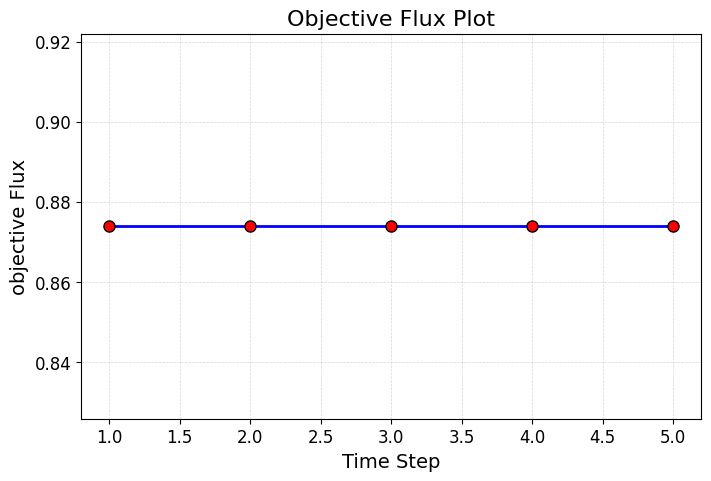

[0.0, 0.873921506968431, 0.873921506968431, 0.873921506968431, 0.873921506968431, 0.873921506968431]


In [9]:
#Objective Flux rate plot
Time_step_data = []
objective_flux_data = []

for key, value in data.items():
    if 'objective_flux_value' in value:
        Time_step_data.append(key)
        objective_flux_data.append(value['objective_flux_value'])

# Filter out data points with a time step of 0
filtered_data = [(t, obj_flux) for t, obj_flux in zip(Time_step_data, objective_flux_data) if t != 0]
filtered_time_step_data, filtered_objective_flux_data = zip(*filtered_data)

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(filtered_time_step_data, filtered_objective_flux_data, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='red', markeredgecolor='black', color='blue')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('objective Flux', fontsize=14)
plt.title('Objective Flux Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('../Plots/objective_flux_plot.png', dpi=300)
plt.show()
print(objective_flux_data)


### Current Biomass
The plot below displays the current biomass at each time-step. The calculation is as follows:

###### Current Biomass = (Current Biomass * Objective Flux Rate * Time Proportion)

Note: Each time-step is considered to be one minute in duration.

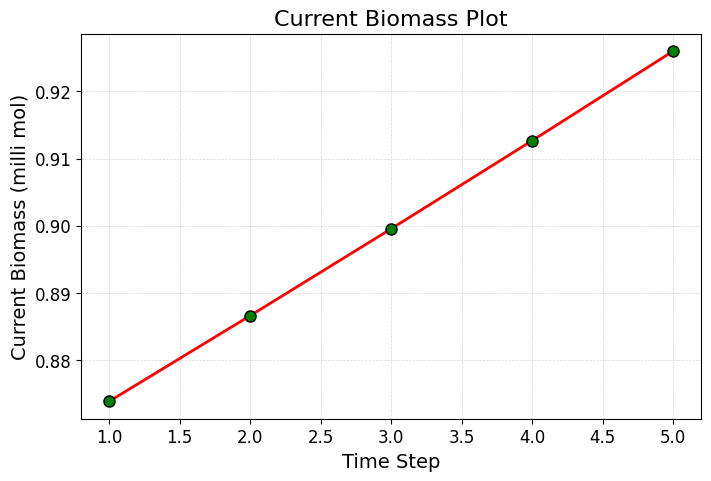

[0.0, 0.8739215069684295, 0.8866504869741291, 0.8995648691363078, 0.9126673539038322, 0.9259606810585743]


In [10]:
Time_step_data = []
current_biomass_value_list = []

for key, value in data.items():
    if 'current_biomass_value' in value:
        Time_step_data.append(key)
        current_biomass_value_list.append(value['current_biomass_value'])

# Filter out data points with a time step of 0
filtered_data = [(t, biomass_val) for t, biomass_val in zip(Time_step_data, current_biomass_value_list) if t != 0]
filtered_time_step_data, filtered_current_biomass_value_list = zip(*filtered_data)

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(filtered_time_step_data, filtered_current_biomass_value_list, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='green', markeredgecolor='black', color='red')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Current Biomass (milli mol)', fontsize=14)
plt.title('Current Biomass Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('../Plots/current_biomass_value_plot.png', dpi=300)
plt.show()
print(current_biomass_value_list)

### Glucose Consumption Plot
The plot below illustrates the cumulative environmental consumption (glucose in this case) at each time-step. Environmental consumption is a function of time, biomass, flux, and glucose availability.

#### Units: 
The current_biomass is measured in gDW/L (grams of dry weight per liter), fluxes_values ["EX_glc__D_e"] is in mmol gDW^(-1) h^(-1), and the time proportion factor (1/60) h converts the rate from per hour to per minute. Therefore, the units in the formula cancel out to give mmol, representing the amount of glucose consumed.

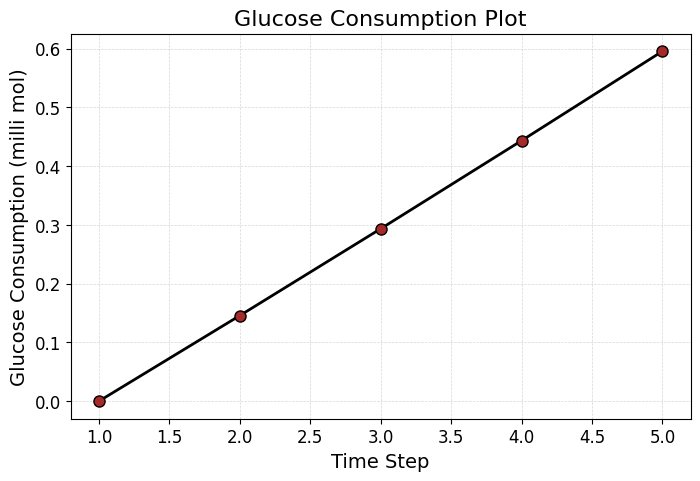

[0.0, 0.0, 0.14565358449473825, 0.29342866565709314, 0.44335614384647776, 0.5954673694971164]


In [11]:
Time_step_data = []
current_env_consumption_value_list = []

for key, value in data.items():
    if 'current_env_consumption_value' in value:
        Time_step_data.append(key)
        current_env_consumption_value_list.append(value['current_env_consumption_value'])
        
# Convert the list to absolute values
abs_current_env_consumption_value_list = [abs(val) for val in current_env_consumption_value_list]

# Filter out data points with a time step of 0
filtered_data = [(t, abs_env_consumption_val) for t, abs_env_consumption_val in zip(Time_step_data, abs_current_env_consumption_value_list) if t != 0]
filtered_time_step_data, filtered_abs_current_env_consumption_value_list = zip(*filtered_data)

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(filtered_time_step_data, filtered_abs_current_env_consumption_value_list, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='brown', markeredgecolor='black', color='black')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Glucose Consumption (milli mol)', fontsize=14)
plt.title('Glucose Consumption Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('../Plots/abs_current_env_consumption_value_plot.png', dpi=300)
plt.show()
print(current_env_consumption_value_list)


In [12]:
# Time_step_data = []
# concentration_list = []

# for key, value in data.items():
#     if 'concentration' in value:
#         Time_step_data.append(key)
#         concentration_list.append(value['concentration'])
# print(Time_step_data)        
# print(concentration_list)

### Calculating the Vmax:
V0 = (Vmax * [S]) / (Km + [S])


[S] = Substrate concentration (glucose concentration)
V0 = Initial velocity of the reaction
Km = Michaelis constant


#### In our example: 
V0 = 10 mmol gDW^(-1) h^(-1)


Glucose concentration = 2 grams of glucose per liter
(2 g/L) * (1 mol / 180.16 g) * 1000 = 11.11 mmol/L


Km = glucose concentration/1000     #For now we consider it a very low number
11.11/1000 =  0.01111 mmol gDW^(-1)


Since we now have values for V0, [S], and Km, we can rearrange the Michaelis-Menten equation to solve for Vmax:


Vmax = (V0 * (Km + [S])) / [S]


The Vmax in this case is approximately 10.01 mmol gDW^(-1) h^(-1)


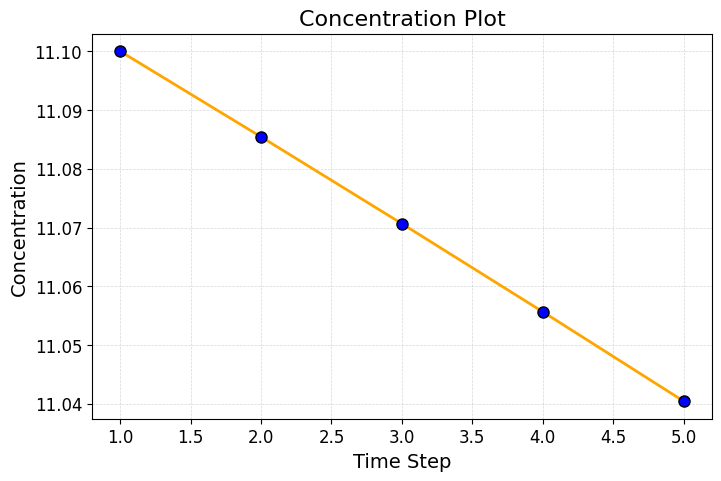

[11.1, 11.1, 11.085434641550526, 11.07065713343429, 11.055664385615351, 11.040453263050287]


In [13]:
Time_step_data = []
concentration_list = []


for key, value in data.items():
    if 'concentration' in value:
        Time_step_data.append(key)
        concentration_list.append(value['concentration']) 

# Filter out data points with a time step of 0
filtered_data = [(t, concentration_val) for t, concentration_val in zip(Time_step_data, concentration_list) if t != 0]
filtered_time_step_data, filtered_concentration_list = zip(*filtered_data)

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(filtered_time_step_data, filtered_concentration_list, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='blue', markeredgecolor='black', color='orange')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Concentration', fontsize=14)
plt.title('Concentration Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('../Plots/concentration_plot.png', dpi=300)
plt.show()


print(concentration_list)

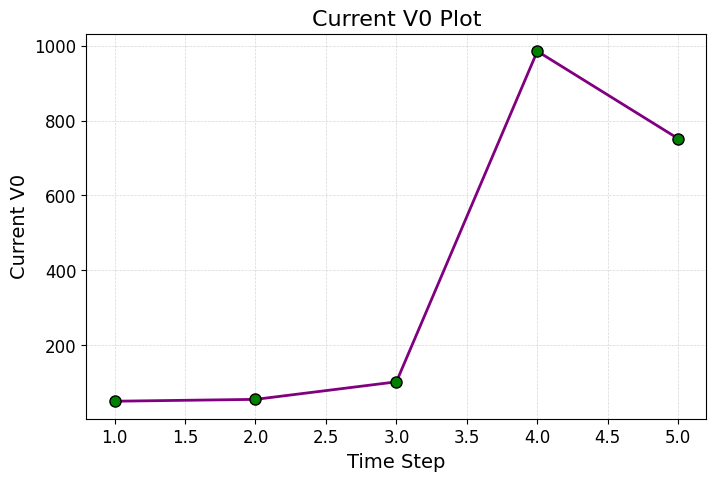

[10.0, 49.55357142857143, 54.50892857142858, 101.3779122153713, 985.2053712758951, 751.4443672753025]


In [14]:
Time_step_data = []
Current_V0_list = []
for key, value in data.items():
    if 'current_v0' in value:
        Time_step_data.append(key)
        Current_V0_list.append(value['current_v0']) 

        
# Filter out data points with a time step of 0
filtered_data = [(t, V0_val) for t, V0_val in zip(Time_step_data, Current_V0_list) if t != 0]
filtered_time_step_data, filtered_Current_V0_list = zip(*filtered_data)

plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(filtered_time_step_data, filtered_Current_V0_list, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='green', markeredgecolor='black', color='purple')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Current V0', fontsize=14)
plt.title('Current V0 Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.savefig('../Plots/current_V0_plot.png', dpi=300)
plt.show()

print(Current_V0_list)


### Escher Plot
Escher plots are interactive visualizations of metabolic networks and pathways using the Escher software, particularly useful for displaying and analyzing results from FBA or dFBA. By overlaying predicted flux values on the metabolic network, Escher plots offer insights into metabolite flow and reaction activity under various conditions. In the following plot, users can select the time-step of the simulation for which they want to view the Escher plot.

In [ ]:
# #Escher plot

# # Set the desired time-step
# requested_time_step = 2
# Flux_data_list=[]
# # Get the index of the requested time-step in Time_step_data
# index = Time_step_data.index(requested_time_step)

# for key, value in data.items():
#     if 'fluxes_values' in value:
#         Time_step_data.append(key)
#         Flux_data_list.append(value['fluxes_values'])

# # Get the flux_data for the requested time-step
# flux_data = Flux_data_list[index]

# # Visualize the metabolic pathways for the requested time-step
# from escher import Builder

# # Load the E. coli core map
# builder = Builder(
#     map_name="e_coli_core.Core metabolism",  # user should choose it.
#     reaction_data=flux_data,
#     show_gene_reaction_rules=False,
# )

# # Save the Escher plot as an HTML file with a unique name for the requested time step
# builder.save_html(f"../Plots/escher_plot__dFBA_time_step_{requested_time_step}.html")

# builder


In [ ]:
Time_step_data = []
glu_list = []
for key, value in data.items():
    if 'reaction_bounds' in value:
        Time_step_data.append(key)
        glu_list.append(value['reaction_bounds']['EX_glc__D_e'])
print(glu_list)